# Re-evaluate test set scores

### Setup

In [27]:
import os
import pandas as pd
import math
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datasets import Dataset, load_dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import pipeline

import torch
from torch.utils.data import DataLoader

from rdkit import Chem
from collections import Counter
from copy import deepcopy

from scipy.special import softmax

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

### Evaluate FART models on clean test set


In [28]:
test_cleaned = pd.read_csv("test_cleaned.csv")
test_dataset = Dataset.from_pandas(test_cleaned)

In [29]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(test_dataset['Canonicalized Taste'])
test_dataset = test_dataset.add_column('label', encoded_labels)
label_names = label_encoder.inverse_transform(range(5))

In [30]:
#tokenizer = AutoTokenizer.from_pretrained("FartLabs/FART_Augmented")
model_checkpoint = "seyonec/SMILES_tokenized_PubChem_shard00_160k"  # Edit this line to use a different pretrained model

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize_function(examples):
    return tokenizer(examples["Canonicalized SMILES"], padding="max_length", truncation=True, max_length=512)

In [31]:
#model = AutoModelForSequenceClassification.from_pretrained("FartLabs/FART_Augmented")
model = AutoModelForSequenceClassification.from_pretrained("FartLabs/FART_Canonical")

In [32]:
x = test_dataset.map(tokenize_function, batched=True)

cols = ["input_ids", "attention_mask"]
if "token_type_ids" in x.column_names:
    cols.append("token_type_ids")

x.set_format(type="torch", columns=cols)

Map: 100%|██████████| 2239/2239 [00:00<00:00, 13704.66 examples/s]


In [33]:
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
loader = DataLoader(x, batch_size=16, shuffle=False, collate_fn=collator)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [34]:
all_probs, all_preds = [], []

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items() if k in cols}
        outputs = model(**batch)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

In [35]:
probs = torch.cat(all_probs, dim=0).numpy()
pred_labels = torch.cat(all_preds, dim=0).numpy()

### Metrics

In [36]:
true_labels = encoded_labels

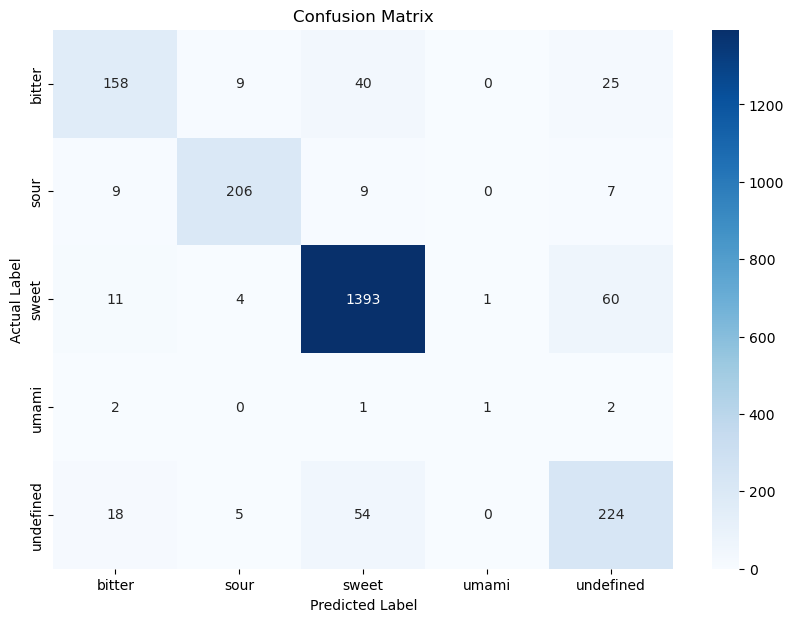

In [37]:
# Create confusion matrix

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)

plt.title('Confusion Matrix')

plt.ylabel('Actual Label')

plt.xlabel('Predicted Label')

plt.show()


In [38]:
# Calculate accuracy

accuracy = accuracy_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.4f}")



# Calculate precision, recall, and F1 score for each class

precision, recall, f1, support = precision_recall_fscore_support(true_labels, pred_labels)



# Optionally, if you want to calculate the weighted scores as well

precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')

print(f"Weighted Precision: {precision_weighted:.4f}")

print(f"Weighted Recall: {recall_weighted:.4f}")

print(f"Weighted F1 Score: {f1_weighted:.4f}")

class_names = label_encoder.classes_

for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):

    print(f"Class {class_names[i]}:")

    print(f"  Precision: {p:.4f}")

    print(f"  Recall: {r:.4f}")

    print(f"  F1 Score: {f:.4f}")

    print(f"  Support: {s}")

Accuracy: 0.8852
Weighted Precision: 0.7705
Weighted Recall: 0.6864
Weighted F1 Score: 0.7107
Class bitter:
  Precision: 0.7980
  Recall: 0.6810
  F1 Score: 0.7349
  Support: 232
Class sour:
  Precision: 0.9196
  Recall: 0.8918
  F1 Score: 0.9055
  Support: 231
Class sweet:
  Precision: 0.9305
  Recall: 0.9483
  F1 Score: 0.9393
  Support: 1469
Class umami:
  Precision: 0.5000
  Recall: 0.1667
  F1 Score: 0.2500
  Support: 6
Class undefined:
  Precision: 0.7044
  Recall: 0.7442
  F1 Score: 0.7237
  Support: 301


Unweighted AUROC: 0.9638


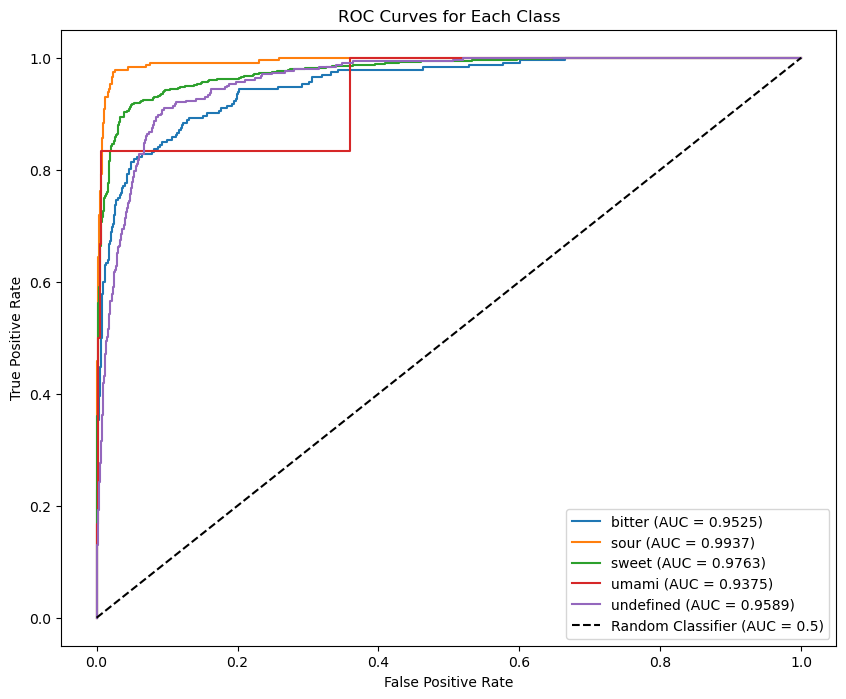

In [39]:
# Plot ROC curves for each class

num_classes = probs.shape[1]

# Binarize the true labels
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

class_labels = label_encoder.inverse_transform(range(5))

plt.figure(figsize=(10, 8))
auc_scores = []
for i in range(num_classes):
    if np.sum(true_labels_bin[:, i]) > 0:  # Check if the class is in y_true
        auc = roc_auc_score(true_labels_bin[:, i], probs[:, i])
        auc_scores.append(auc)
        fpr, tpr, _ = roc_curve(true_labels_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc:.4f})")
    else:
        print(f"{class_labels[i]} not present in true_labels.")

print(f"Unweighted AUROC: {np.mean(auc_scores):.4f}")

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.savefig('figures/ROC.pdf')